In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk

import re
import seaborn as sns
import matplotlib.pyplot as plt

# Download required NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab') # Download the missing 'punkt_tab' resource

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:

# Preprocess text
def preprocess_text(text):
    # Lowercase text
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join tokens back to string
    return ' '.join(tokens)

In [ ]:
# Load data
prod_df = pd.read_csv('/content/My_Product_Descriptions - Sheet1.csv')
# Combine "Product Name" and "Description" into a single "Doc" column
prod_df['Doc'] = (prod_df['Product Name'] + ' ' + prod_df['Description']).fillna('')

# Apply preprocessing
prod_df['Doc'] = prod_df['Doc'].apply(preprocess_text)

In [ ]:
prod_df['Doc'][0]

'classic cotton tee comfortable lightweight cotton tshirt perfect casual wear'

In [ ]:
# Stratified train-test split based on "Category"
X = prod_df['Doc']
y = prod_df['Category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Vectorize using TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train logistic regression model
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = model.predict(X_test_tfidf)

In [ ]:
# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.95


In [ ]:
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

      Coffee       1.00      1.00      1.00         4
    Lipstick       1.00      1.00      1.00         4
       Phone       1.00      1.00      1.00         4
       Shoes       1.00      0.75      0.86         4
     T-shirt       0.80      1.00      0.89         4

    accuracy                           0.95        20
   macro avg       0.96      0.95      0.95        20
weighted avg       0.96      0.95      0.95        20



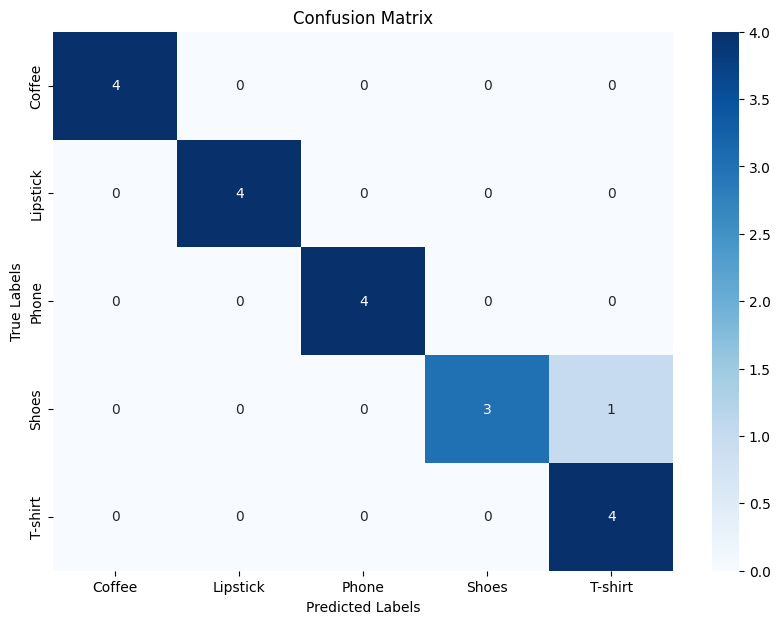

In [ ]:
# Visualize confusion matrix using seaborn
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Inference examples
def make_inference(text):
    processed_text = preprocess_text(text)
    vectorized_text = vectorizer.transform([processed_text])
    prediction = model.predict(vectorized_text)
    return prediction[0]

# JSON input for inference
examples = {
    "examples": [
        {"Product Name": "BEST Tshirt", "Description": "A state-of-the-art tshirt with sleek design."},
        {"Product Name": "Coffee Blend A", "Description": "A rich, aromatic coffee blend perfect for connoisseurs."}
    ]
}

# Convert examples to DataFrame
examples_df = pd.DataFrame(examples["examples"])
examples_df

,Product Name,Description
0,BEST Tshirt,A state-of-the-art tshirt with sleek design.
1,Coffee Blend A,"A rich, aromatic coffee blend perfect for conn..."


In [ ]:
examples_df["Combined"] = examples_df["Product Name"] + ' ' + examples_df["Description"]
examples_df["Prediction"] = examples_df["Combined"].apply(make_inference)
examples_df.drop(['Combined'], axis=1, inplace=True)
examples_df


,Product Name,Description,Prediction
0,BEST Tshirt,A state-of-the-art tshirt with sleek design.,T-shirt
1,Coffee Blend A,"A rich, aromatic coffee blend perfect for conn...",Coffee


In [ ]:

# Find similar products based on search query
def find_similar_products(query, top_n=3):
    processed_query = preprocess_text(query)
    query_vector = vectorizer.transform([processed_query])
    similarities = cosine_similarity(query_vector, vectorizer.transform(prod_df['Doc']))
    prod_df['Similarity'] = similarities[0]
    top_matches = prod_df.sort_values(by='Similarity', ascending=False).head(top_n)
    return top_matches[['Product Name', 'Description', 'Category', 'Similarity']]


In [ ]:
# Example query
search_query = "I want black coffee"
similar_products = find_similar_products(search_query)
similar_products

,Product Name,Description,Category,Similarity
89,Mocha Coffee Mix,Indulgent mocha coffee mix for a chocolatey tr...,Coffee,1.000000
98,Black Owl Coffee,A rich and bold coffee blend for discerning ta...,Coffee,0.530730
85,Organic Coffee Beans,Sustainably sourced organic coffee for a guilt...,Coffee,0.439996
